### Importy

In [16]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# w celu logowania czasu wykonania
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

### Prosty autoenkoder

Określamy wymiar przestrzeni ukrytej (im niższy wymiar tym bardziej skompresowane dane) i budujemy model autoenkodera

In [2]:
encoding_dim = 15  # wymiar kodowania skompresowanego
input_img = Input(shape=(784,), name='Warstwa_wejściowa') # warstwa wejsciowa
encoded = Dense(encoding_dim, activation='relu', name='Enkoder')(input_img) # reprezentacja zakodowana
decoded = Dense(784, activation='sigmoid', name='Dekoder')(encoded) # reprezentacja zdekodowana
autoencoder = Model(input_img, decoded, name='Prosty_autoenkoder') # model autoenkodera

Tworzymy enkoder i dekoder

In [3]:
encoder = Model(input_img, encoded) # model enkodera
encoded_input = Input(shape=(encoding_dim,)) # input dla dekodera
decoder_layer = autoencoder.layers[-1] # ostatnia warstwa autoenkodera czyli dekoder
decoder = Model(encoded_input, decoder_layer(encoded_input)) # model dekodera

Ustawiamy optymalizator i funkcję straty

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Wczytanie zbioru danych MNIST 

In [5]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Przykładowe obrazy ze zbioru treningowego:

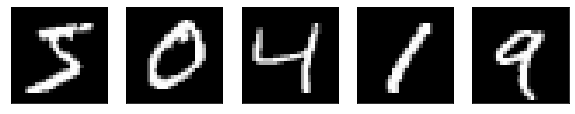

In [6]:
plt.figure(figsize=(10, 4))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Trenujemy model autoenkodera

In [22]:
time_callback = TimeHistory()

In [23]:
history=autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=256,
                validation_data=(x_test, x_test),
                callbacks=[time_callback])

Epoch 1/15
235/235 [==============================] - 5s 21ms/step - loss: 0.1349 - val_loss: 0.1335
Epoch 2/15
235/235 [==============================] - 5s 20ms/step - loss: 0.1346 - val_loss: 0.1332
Epoch 3/15
235/235 [==============================] - 5s 19ms/step - loss: 0.1343 - val_loss: 0.1330
Epoch 4/15
235/235 [==============================] - 4s 19ms/step - loss: 0.1341 - val_loss: 0.1329
Epoch 5/15
235/235 [==============================] - 4s 18ms/step - loss: 0.1339 - val_loss: 0.1326
Epoch 6/15
235/235 [==============================] - 5s 20ms/step - loss: 0.1337 - val_loss: 0.1324
Epoch 7/15
235/235 [==============================] - 5s 20ms/step - loss: 0.1336 - val_loss: 0.1323
Epoch 8/15
235/235 [==============================] - 4s 18ms/step - loss: 0.1334 - val_loss: 0.1322
Epoch 9/15
235/235 [==============================] - 5s 21ms/step - loss: 0.1333 - val_loss: 0.1320
Epoch 10/15
235/235 [==============================] - 5s 22ms/step - loss: 0.1332 - val_lo

Stosujemy enkoder i dekoder na zbiorze testowym. Wyświetlamy oryginalne obrazy ze zbioru testowego oraz ich rekonstrukcje z autoenkodera

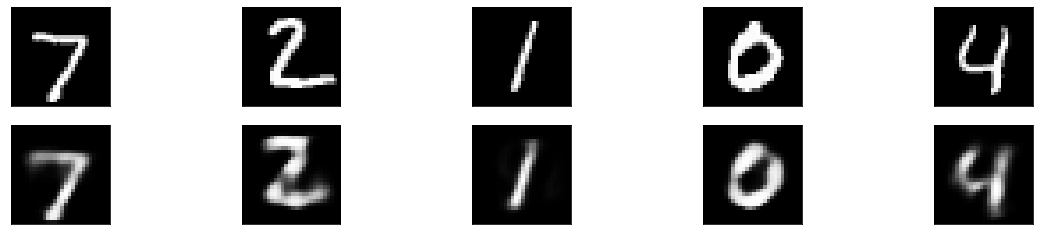

In [8]:
encoded_img = encoder.predict(x_test)
decoded_img = decoder.predict(encoded_img)
plt.figure(figsize=(20, 4))
for i in range(5):
    #wyswietlanie oryginalu
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # wyswietlanie rekonstrukcji
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Jak wygląda skompresowana forma danych?

Zbiór testowy po zakodowaniu przy użyciu enkodera ma wymiar 10000 na 15, czyli zawiera 10 tysięcy obserwacji, każda jest wektorem o długości 15 (wejściowe obrazy były przedstawione jako wektory o długości 784).

In [9]:
encoded_img.shape

(10000, 15)

Przykładowe kodowanie obserwacji ze zbioru testowego:

In [10]:
encoded_img[0]

array([11.344408 ,  9.887121 ,  3.7241054,  9.919837 ,  3.0924015,
       12.554805 , 16.64782  ,  6.0366845,  0.       ,  0.9262277,
       12.766998 , 11.932495 ,  4.4192133,  7.9177785, 11.1360855],
      dtype=float32)

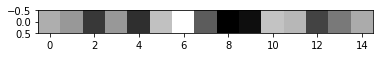

In [11]:
#plt.figure(figsize=(4, 8))
plt.imshow(encoded_img[0].reshape(1,15))
plt.show()

In [12]:
autoencoder.summary()

Model: "Prosty_autoenkoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Warstwa_wejściowa (InputLay  [(None, 784)]            0         
 er)                                                             
                                                                 
 Enkoder (Dense)             (None, 15)                11775     
                                                                 
 Dekoder (Dense)             (None, 784)               12544     
                                                                 
Total params: 24,319
Trainable params: 24,319
Non-trainable params: 0
_________________________________________________________________


In [13]:
loss=history.history['loss']
epoch=history.epoch

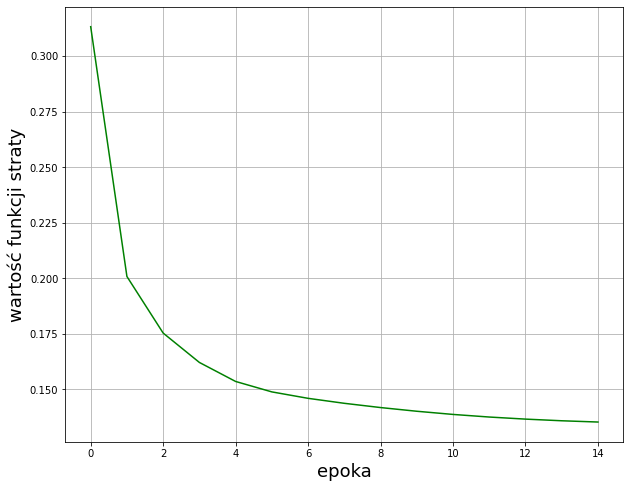

In [14]:
fig = plt.figure(figsize=(10,8))
plt.plot(epoch, loss, 'g')
plt.ylabel("wartość funkcji straty", fontsize=18)
plt.xlabel("epoka", fontsize=18)
plt.grid(True)
plt.show()

In [16]:
autoencoder.save_weights('simple_autoencoder.h5')

In [26]:
time_callback.times

[5.067455053329468,
 4.6783833503723145,
 4.564964294433594,
 4.43439793586731,
 4.306335926055908,
 4.757062196731567,
 4.766044616699219,
 4.200185775756836,
 4.9463791847229,
 5.059286832809448,
 4.8079938888549805,
 5.452341318130493,
 6.669023752212524,
 5.706934213638306,
 5.424026727676392]

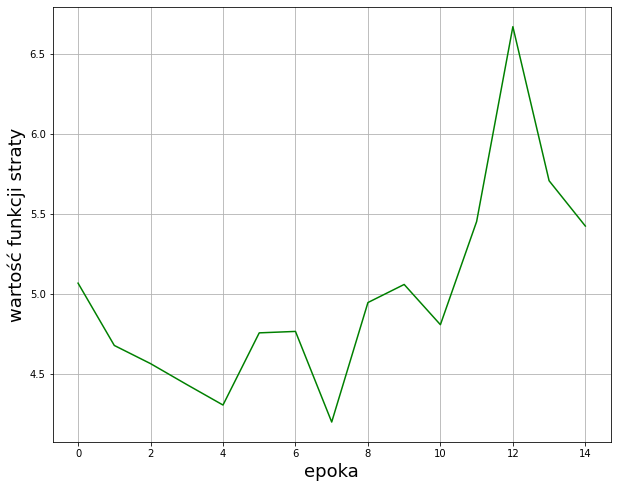

In [27]:
fig = plt.figure(figsize=(10,8))
plt.plot(epoch, time_callback.times, 'g')
plt.ylabel("wartość funkcji straty", fontsize=18)
plt.xlabel("epoka", fontsize=18)
plt.grid(True)
plt.show()